In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
import random

Downlaod the Datasets from "https://github.com/phoebetronic/mnist"

In [10]:
mnist_train = "data/mnist_train.csv"
mnist_test = "data/mnist_test.csv"

In [11]:
train_file = open(mnist_train, "r")
train_list = train_file.readlines()
train_file.close()
print(len(train_list))

test_file = open(mnist_test, "r")
test_list = test_file.readlines()
test_file.close()
print(len(test_list))


60000
10000


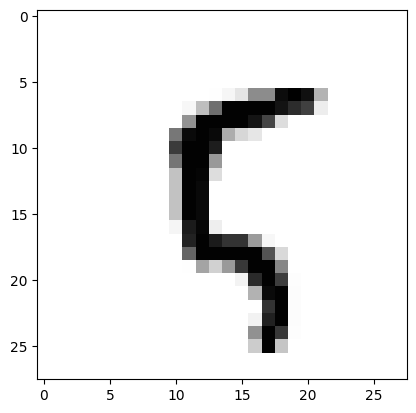

In [12]:
values = train_list[100].split(",")
image_array = np.asarray(values[1:], dtype=np.float32).reshape((28,28))
plt.imshow(image_array, cmap="Greys", interpolation="None")

# Neuronal Network


In [26]:
class DenseNeuronalNetwork:
    def __init__(self, sizes, learningRate):
        self.sizes = sizes
        self.learningRate = learningRate

        input_layer = sizes[0]
        hidden_layer_1 = sizes[1]
        hidden_layer_2= sizes[2]
        output_layer = sizes[3]

        self.params = {
            'weight1': np.random.randn(hidden_layer_1, input_layer) * np.sqrt(1 / hidden_layer_1),
            'weight2': np.random.randn(hidden_layer_2, hidden_layer_1) * np.sqrt(1 / hidden_layer_2),
            'weight3': np.random.randn(output_layer, hidden_layer_2) * np.sqrt(1 / output_layer)
        }

    def sigmoid(self, x, derivatative=False):
        sig = 1/(1 + np.exp(-x))

        if derivatative:
            return(sig * (1-sig))
        return(sig)
    
    def softmax(self, x, derivatative=False):
        exps = np.exp(x - x.max())
        if derivatative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        # Input Layer to Hidden Layer 1
        params['Z1'] = np.dot(params['weight1'], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # Hidden layer 1 to Hidden Layer 2
        params['Z2'] = np.dot(params['weight2'], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # Hidden Layer 2 to Output Layer
        params['Z3'] = np.dot(params['weight3'], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params

        change_weight = {}

        # Calculate the weight3 Update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivatative=True)
        change_weight['weight3'] = np.outer(error, params['A2'])

        # Calculate the weight2 Update
        error  = np.dot(params['weight3'].T, error) * self.sigmoid(params['Z2'], derivatative=True)
        change_weight['weight2'] = np.outer(error, params['A1'])

         # Calculate the weight1 Update
        error  = np.dot(params['weight2'].T, error) * self.sigmoid(params['Z1'], derivatative=True)
        change_weight['weight1'] = np.outer(error, params['A0'])

        return change_weight

    def update_weights(self, change_weight):
        for key, val in change_weight.items():
            self.params[key] -= self.learningRate * val

    def accuracy(self, test_data):
        predictions = []
        for x in test_data:
            values = x.split(",")
            inputs = (np.asarray(values[1:], dtype=np.float32) / 255.0 *0.99) + 0.01
            targets = np.zeros(10) + 0.01
            targets[int(values[0])] = 0.99
            output = self.forward_pass(inputs)
            prediction = np.argmax(output)
            predictions.append(prediction == np.argmax(targets))

        return np.mean(predictions)
            

    def train(self, train_list, test_list, epochs, batch_size=32):
        for i in range(epochs):
            start_time = time.time()
            random.shuffle(train_list)
            batch_gradients = {key: 0 for key in self.params if "weight" in key}

            for idx, x in enumerate(train_list):
                values = x.split(",")
                inputs = (np.asarray(values[1:], dtype=np.float32) / 255.0 *0.99) + 0.01
                targets = np.zeros(10) + 0.01
                targets[int(values[0])] = 0.99

                output = self.forward_pass(inputs)
                change_weight = self.backward_pass(targets, output)

                for key in batch_gradients:
                    batch_gradients[key] += change_weight[key]
                
                if (idx +1) % batch_size == 0:
                    avg_gradients = {key: value / batch_size for key, value in batch_gradients.items()}
                    self.update_weights(avg_gradients)
                    batch_gradients = {key: 0 for key in self.params if "weight" in key}

            accuracy = self.accuracy(test_list)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(i+1, time.time() - start_time, accuracy * 100))
        

# To Create a new Model

```python
sizes = [784, 128, 64, 10]
denseNeuronalNetwork = DenseNeuronalNetwork(sizes, learningRate=0.001)

with open("model.pkl", "wb") as f:
    pickle.dump(denseNeuronalNetwork, f)
```

In [ ]:
# Open saved Model
modelname = "model_with_batch.pkl"

with open(modelname, "rb") as f:
    loaded_model = pickle.load(f)

accuracy = loaded_model.accuracy(test_list)
print("Curernt Accurancy:", accuracy*100)


# Train the Model

loaded_model.train(train_list, test_list, epochs=20)

with open(modelname, "wb") as f:
    pickle.dump(loaded_model, f)